In [6]:
!pip install librosa
!pip install waves


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Librerías

In [63]:
import wave
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import librosa
import tensorflow as tf
import keras_tuner as kt
import librosa.display
import random
import pickle
from PIL import Image
from kerastuner.tuners import RandomSearch
from keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [64]:
pathAudioNorm = '/norm/'
pathAudioPatho = '/patho/'
path = 'data'

In [65]:
dfCopy = pd.DataFrame(columns=['audio', 'type', 'duration'])

def readAudioFiles(pathAudioType, dfCopy, tipo):
    for file in os.listdir(pathAudioType):
        if not file.endswith('.wav'):
            continue
        with wave.open(os.path.join(pathAudioType, file), 'rb') as audioFile:
            amountFrames = audioFile.getnframes()
            frameRate = audioFile.getframerate()  # Obtener la frecuencia de muestreo
            duration = amountFrames / frameRate  # Calcular la duración en segundos
            datosAudio = audioFile.readframes(amountFrames)
            audioArray = np.frombuffer(datosAudio, dtype=np.int16).astype(np.float32) / 32767.0
            dfNew = pd.DataFrame({'audio': [audioArray], 'type': [tipo], 'duration': [duration]})
            dfCopy = pd.concat([dfCopy, dfNew], ignore_index=True)
    return dfCopy

dfCopy = readAudioFiles(path + pathAudioNorm, dfCopy, 'norm')
dfCopy = readAudioFiles(path + pathAudioPatho, dfCopy, 'patho')

average_duration = dfCopy[dfCopy['type'] == 'patho']['duration'].mean()
print(f'La duración promedio de los audios tipo norm es: {average_duration} segundos')

La duración promedio de los audios tipo norm es: 1.003843005780347 segundos


C:\Users\Wembie\AppData\Local\Temp\ipykernel_12312\2063783998.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfCopy = pd.concat([dfCopy, dfNew], ignore_index=True)


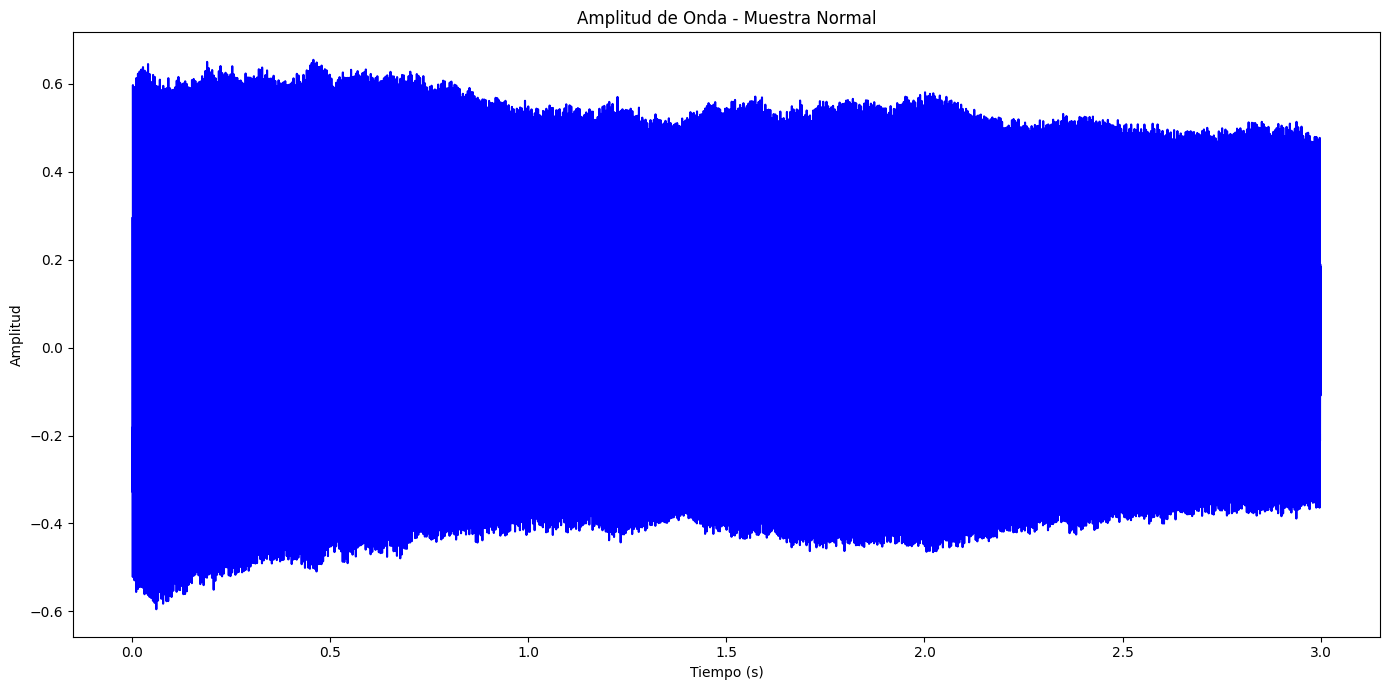

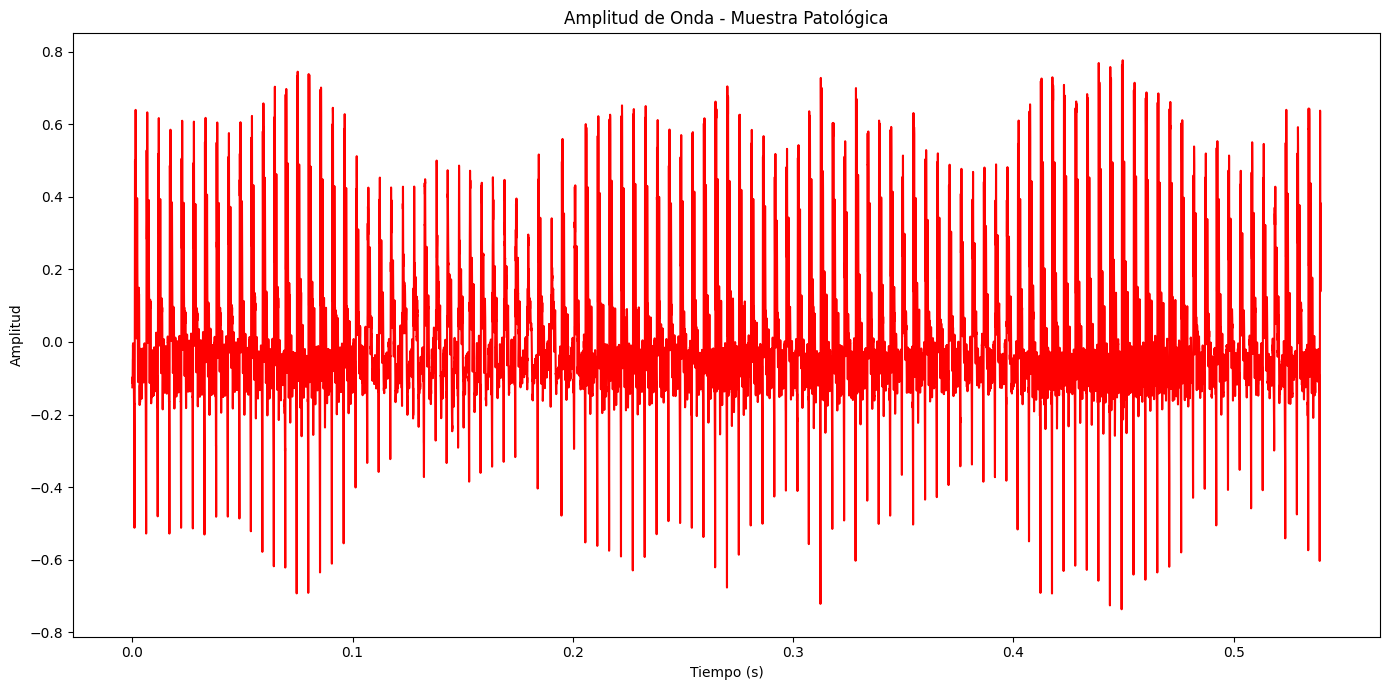

In [66]:
# Seleccionar una muestra de cada tipo
norm_sample = dfCopy[dfCopy['type'] == 'norm'].iloc[0]['audio']
patho_sample = dfCopy[dfCopy['type'] == 'patho'].iloc[5]['audio']

# Calcular el tiempo correspondiente a cada muestra
norm_time = np.linspace(0, len(norm_sample) / 50000, num=len(norm_sample))
patho_time = np.linspace(0, len(patho_sample) / 50000, num=len(patho_sample))

# Crear la gráfica de la amplitud de onda para la muestra normal
plt.figure(figsize=(14, 7))
plt.plot(norm_time, norm_sample, color='blue')
plt.title('Amplitud de Onda - Muestra Normal')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.tight_layout()
plt.savefig('amplitud_onda_muestra_normal.png')
plt.show()

# Crear la gráfica de la amplitud de onda para la muestra patológica
plt.figure(figsize=(14, 7))
plt.plot(patho_time, patho_sample, color='red')
plt.title('Amplitud de Onda - Muestra Patológica')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.tight_layout()
plt.savefig('amplitud_onda_muestra_patologica.png')
plt.show()

In [67]:
df = pd.DataFrame( columns = ['audio', 'type'] )

def readAudioFiles( pathAudioType, df, tipo ):
    for file in os.listdir( path + pathAudioType ):
        if not file.endswith( '.wav' ):
            continue
        with wave.open( path + pathAudioType + file, 'rb' ) as audioFile:
            amountFrames = audioFile.getnframes()
            datosAudio = audioFile.readframes( amountFrames )
            audioArray = np.frombuffer( datosAudio, dtype=np.int16 ).astype( np.float32) / 32767.0
            dfNew = pd.DataFrame( { 'audio': [ audioArray ], 'type': [ tipo ] } )
            df = pd.concat( [ df, dfNew ], ignore_index = True )
    return df

df = readAudioFiles( pathAudioNorm, df, 'norm' )
df = readAudioFiles( pathAudioPatho, df, 'patho' )

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   audio   226 non-null    object
 1   type    226 non-null    object
dtypes: object(2)
memory usage: 3.7+ KB


In [69]:
minimal = df['audio'].apply( lambda x: len(x) ).min()
maximum = df['audio'].apply( lambda x: len(x) ).max()
print(minimal, maximum)
# for column, row in df.iterrows():
#    print(len(row['audio']))

11263 150001


In [70]:
amount = df['audio'].apply(len) < 75000
print(amount)

0      False
1      False
2      False
3      False
4      False
       ...  
221     True
222     True
223     True
224     True
225     True
Name: audio, Length: 226, dtype: bool


In [71]:
duracion = df['audio'].apply(len).sum()
print(amount.sum() / 226)

0.7654867256637168


In [72]:
def normalizeAudio( df, duracionFrames ):
    for column, row in df.iterrows():
        if len(row['audio']) > duracionFrames:
            df.at[column, 'audio'] = row['audio'][0:duracionFrames]
        else:
            df.at[column, 'audio'] = np.pad( row['audio'], (0, duracionFrames - len(row['audio'])), 'constant' )
    return df

In [73]:
dfNormalizado = normalizeAudio( df, 57170 )

In [74]:
for column, row in dfNormalizado.iterrows():
    print(len(row['audio']))

57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
57170
5717

In [75]:
def timeShift(audioArray, shift):
    if shift > 0:
        return np.concatenate([np.zeros(shift), audioArray[:-shift]])
    elif shift < 0:
        return np.concatenate([audioArray[-shift:], np.zeros(-shift)])
    return audioArray

In [76]:
def applyTimeShiftAugmentation(df, maxShiftPct=0.1):
    dfAugmented = pd.DataFrame(columns=['audio', 'type'])

    for index, row in df.iterrows():
        audioArray = row['audio']
        tipo = row['type']

        amountFrames = len(audioArray)
        shiftAmount = np.random.randint(-int(amountFrames * maxShiftPct), int(amountFrames * maxShiftPct))

        shiftedAudioArray = timeShift(audioArray, shiftAmount)

        dfNew = pd.DataFrame({'audio': [shiftedAudioArray], 'type': [tipo]})
        dfAugmented = pd.concat([dfAugmented, dfNew], ignore_index=True)

    dfResult = pd.concat([df, dfAugmented], ignore_index=True)

    return dfResult

In [77]:
dfAugmented = applyTimeShiftAugmentation(dfNormalizado)

In [78]:
print(dfAugmented)

                                                 audio   type
0    [0.29456466, 0.2713706, 0.25086215, 0.2230903,...   norm
1    [-0.03640858, -0.006286813, 0.022583697, 0.048...   norm
2    [-0.010834071, 0.027497178, 0.066988125, 0.110...   norm
3    [-0.11380352, -0.13516648, -0.15536973, -0.172...   norm
4    [0.02356029, 0.031434067, 0.04235969, 0.043824...   norm
..                                                 ...    ...
447  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  patho
448  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  patho
449  [0.02053895778954029, 0.08163700997829437, 0.0...  patho
450  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  patho
451  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  patho

[452 rows x 2 columns]


In [79]:
print(dfAugmented['type'].value_counts())

type
patho    346
norm     106
Name: count, dtype: int64


In [80]:
X = np.array(dfAugmented['audio'].tolist())

y = dfAugmented['type'].apply(lambda x: 1 if x == 'patho' else 0).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [81]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [82]:
def trainRequestedModel(model, X_train, y_train, X_test, y_test, modelName=None, hyperparameters=None, scoring='f1_maro'):
    if hyperparameters:
        print(f'Training {modelName} with hyperparameters {hyperparameters}')
        modelSearch = RandomizedSearchCV(model, hyperparameters, n_iter=100, cv=5, scoring=scoring, n_jobs=-1)
        modelSearch.fit(X_train, y_train)
        print(f'Best hyperparameters for {modelName}')
        print(modelSearch.best_params_)
        model = modelSearch.best_estimator_
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scoring)
    else:
        print(f'Training {modelName}')
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scoring)

    y_pred = model.predict(X_test)

    print(f'Classification report for {modelName}')
    print(classification_report(y_test, y_pred))
    print(f'Accuracy score for {modelName}')
    print(accuracy_score(y_test, y_pred))
    print(f'Confusion matrix for {modelName}')
    print(confusion_matrix(y_test, y_pred))

# Logistic Regression

In [83]:
log_reg_norm = LogisticRegression()

scores = cross_val_score(log_reg_norm, X_train_scaled, y_train, cv=5, scoring='f1_macro')
print(f'Cross-validation scores: {scores}')
print(f'Average cross-validation score: {np.mean(scores)}')

Cross-validation scores: [0.71814672 0.69197861 0.59821429 0.78947368 0.7       ]
Average cross-validation score: 0.6995626595394396


In [84]:
y_pred_log_reg_norm = cross_val_predict(log_reg_norm, X_test_scaled, y_test, cv=5)

In [85]:
conf_matrix_log_reg_norm = confusion_matrix(y_test, y_pred_log_reg_norm)
print('Confusion Matrix for logistic regression without optimzation:\n', conf_matrix_log_reg_norm)

Confusion Matrix for logistic regression without optimzation:
 [[ 0 21]
 [ 0 70]]


In [86]:
class_report_log_reg_norm = classification_report(y_test, y_pred_log_reg_norm)
print('Classification report for logistic regression without optimzation:\n', class_report_log_reg_norm)

Classification report for logistic regression without optimzation:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.77      1.00      0.87        70

    accuracy                           0.77        91
   macro avg       0.38      0.50      0.43        91
weighted avg       0.59      0.77      0.67        91



d:\Cosas De Webi\Estudio\PROGRAMACION\PYTHON\Tesis\tesis\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Cosas De Webi\Estudio\PROGRAMACION\PYTHON\Tesis\tesis\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Cosas De Webi\Estudio\PROGRAMACION\PYTHON\Tesis\tesis\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [87]:
print('F1-Score:', f1_score(y_test, y_pred_log_reg_norm, average='weighted'))

F1-Score: 0.6688963210702341


## Optimizing

In [88]:
log_reg_opt = LogisticRegression()

param_dist = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-2, 2, 5),
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000]
}

random_search_log_reg = RandomizedSearchCV(log_reg_opt, param_distributions=param_dist, n_iter=100, cv=5, scoring='f1_macro', random_state=42, n_jobs=-1)

random_search_log_reg.fit(X_train_scaled, y_train)

d:\Cosas De Webi\Estudio\PROGRAMACION\PYTHON\Tesis\tesis\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 20 is smaller than n_iter=100. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
d:\Cosas De Webi\Estudio\PROGRAMACION\PYTHON\Tesis\tesis\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                                        'max_iter': [1000],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'saga']},
                   random_state=42, scoring='f1_macro')

In [89]:
print(f'Best parameters found: {random_search_log_reg.best_params_}')

Best parameters found: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 1000, 'C': 0.1}


In [90]:
best_log_reg = random_search_log_reg.best_estimator_
scores = cross_val_score(best_log_reg, X_train, y_train, cv=5, scoring='f1_macro')
print("F1 Macro Scores:", scores)
print("Media F1 Macro Score:", np.mean(scores))

F1 Macro Scores: [0.43410853 0.43307087 0.43307087 0.43307087 0.43307087]
Media F1 Macro Score: 0.43327839833974247


In [91]:
y_pred_log_reg_opt = cross_val_predict(best_log_reg, X_test_scaled, y_test, cv=5)

d:\Cosas De Webi\Estudio\PROGRAMACION\PYTHON\Tesis\tesis\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Cosas De Webi\Estudio\PROGRAMACION\PYTHON\Tesis\tesis\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Cosas De Webi\Estudio\PROGRAMACION\PYTHON\Tesis\tesis\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Cosas De Webi\Estudio\PROGRAMACION\PYTHON\Tesis\tesis\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Cosas De Webi\Estudio\PROGRAMACION\PYTHON\Tesis\tesis\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which 

### Confusion Matrix for logistic regression

In [92]:
conf_matrix_log_reg_opt = confusion_matrix(y_test, y_pred_log_reg_opt)
print('Confusion Matrix for logistic regression with optimzation:\n', conf_matrix_log_reg_opt)

Confusion Matrix for logistic regression with optimzation:
 [[ 6 15]
 [ 8 62]]


### Classification report for logistic regression

In [93]:
class_report_log_reg_opt = classification_report(y_test, y_pred_log_reg_opt)
print('Classification report for logistic regression with optimzation:\n', class_report_log_reg_opt)

Classification report for logistic regression with optimzation:
               precision    recall  f1-score   support

           0       0.43      0.29      0.34        21
           1       0.81      0.89      0.84        70

    accuracy                           0.75        91
   macro avg       0.62      0.59      0.59        91
weighted avg       0.72      0.75      0.73        91



In [94]:
print('F1-Score:', f1_score(y_test, y_pred_log_reg_opt, average='weighted'))

F1-Score: 0.7279958137100995


# Decision Tree 

In [95]:
clfTree_norm = DecisionTreeClassifier(random_state=42)
scores = cross_val_score(clfTree_norm, X_train, y_train, cv=5, scoring='f1_macro')

print(f'Cross-validation scores: {scores}')
print(f'Average cross-validation score: {np.mean(scores)}')

Cross-validation scores: [0.84939581 0.88449198 0.83928571 0.87368421 0.89723094]
Average cross-validation score: 0.8688177326478159


In [96]:
y_pred_tree_norm = cross_val_predict(clfTree_norm, X_test, y_test, cv=5)

In [97]:
conf_matrix_tree_norm = confusion_matrix(y_test, y_pred_tree_norm)
print('Confusion Matrix for decision tree without optimzation:\n', conf_matrix_tree_norm)

Confusion Matrix for decision tree without optimzation:
 [[12  9]
 [ 4 66]]


In [98]:
class_report_tree_norm = classification_report(y_test, y_pred_tree_norm)
print('Classification report for decision tree without optimzation:\n', class_report_tree_norm)

Classification report for decision tree without optimzation:
               precision    recall  f1-score   support

           0       0.75      0.57      0.65        21
           1       0.88      0.94      0.91        70

    accuracy                           0.86        91
   macro avg       0.81      0.76      0.78        91
weighted avg       0.85      0.86      0.85        91



In [99]:
print('F1-Score:', f1_score(y_test, y_pred_tree_norm, average='weighted'))

F1-Score: 0.8499534016775396


## Optimizing

In [100]:
clfTree_opt = DecisionTreeClassifier(random_state=42)

param_dist = {
    'max_depth': [None] + list(np.arange(1, 20)),
    'min_samples_split': np.arange(2, 20),
    'min_samples_leaf': np.arange(1, 20),
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random']
}

random_search_tree = RandomizedSearchCV(clfTree_opt, param_distributions=param_dist, n_iter=100, scoring='f1_macro', cv=5, random_state=42, n_jobs=-1)
random_search_tree.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 1, 2, 3, 4, 5, 6, 7,
                                                      8, 9, 10, 11, 12, 13, 14,
                                                      15, 16, 17, 18, 19],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='f1_macro')

In [101]:
print("Mejores hiperparámetros encontrados decision tree:", random_search_tree.best_params_)

Mejores hiperparámetros encontrados decision tree: {'splitter': 'random', 'min_samples_split': 13, 'min_samples_leaf': 12, 'max_depth': 16, 'criterion': 'gini'}


In [102]:
best_clfTree = random_search_tree.best_estimator_
scores = cross_val_score(best_clfTree, X_train, y_train, cv=5, scoring='f1_macro')
print("F1 Macro Scores:", scores)
print("Media F1 Macro Score:", np.mean(scores))

F1 Macro Scores: [0.94362934 0.8459893  0.96296296 0.96296296 0.94103194]
Media F1 Macro Score: 0.931315303080009


In [103]:
y_pred_tree_opt = cross_val_predict(best_clfTree, X_test, y_test, cv=5)

In [104]:
conf_matrix_tree_opt = confusion_matrix(y_test, y_pred_tree_opt)
print('Confusion Matrix for decision tree with optimzation:\n', conf_matrix_tree_opt)

Confusion Matrix for decision tree with optimzation:
 [[12  9]
 [ 3 67]]


In [105]:
class_report_tree_opt = classification_report(y_test, y_pred_tree_opt)
print('Classification report for decision tree with optimzation:\n', class_report_tree_opt)

Classification report for decision tree with optimzation:
               precision    recall  f1-score   support

           0       0.80      0.57      0.67        21
           1       0.88      0.96      0.92        70

    accuracy                           0.87        91
   macro avg       0.84      0.76      0.79        91
weighted avg       0.86      0.87      0.86        91



In [106]:
print('F1-Score:', f1_score(y_test, y_pred_tree_opt, average='weighted'))

F1-Score: 0.8598524762908325


# Random Forest

In [107]:
clfForest_norm = RandomForestClassifier(random_state=42)
scores = cross_val_score(clfForest_norm, X_train, y_train, cv=5, scoring='f1_macro')
print(f'Cross-validation scores: {scores}')
print(f'Average cross-validation score: {np.mean(scores)}')

Cross-validation scores: [0.94569799 0.92299465 0.96296296 0.92299465 0.96296296]
Average cross-validation score: 0.9435226444616622


In [108]:
y_pred_forest_norm = cross_val_predict(clfForest_norm, X_test, y_test, cv=5)

In [109]:
conf_matrix_forest_norm = confusion_matrix(y_test, y_pred_forest_norm)
print('Confusion Matrix for random forest without optimzation:\n', conf_matrix_forest_norm)

Confusion Matrix for random forest without optimzation:
 [[17  4]
 [ 0 70]]


In [110]:
class_report_forest_norm = classification_report(y_test, y_pred_forest_norm)
print('Classification report for random forest without optimzation:\n', class_report_forest_norm)

Classification report for random forest without optimzation:
               precision    recall  f1-score   support

           0       1.00      0.81      0.89        21
           1       0.95      1.00      0.97        70

    accuracy                           0.96        91
   macro avg       0.97      0.90      0.93        91
weighted avg       0.96      0.96      0.95        91



In [111]:
print('F1-Score:', f1_score(y_test, y_pred_forest_norm, average='weighted'))

F1-Score: 0.9543409806567702


## Optimizing

In [112]:
clfForestHypSearch = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': np.arange(10, 200, 10),
    'max_depth': [None] + list(np.arange(1, 20)),
    'min_samples_split': np.arange(2, 20),
    'min_samples_leaf': np.arange(1, 20),
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

random_search_forest = RandomizedSearchCV(clfForestHypSearch, param_distributions=param_dist, n_iter=100, scoring='f1_macro', cv=5, random_state=42, n_jobs=-1)

random_search_forest.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 1, 2, 3, 4, 5, 6, 7,
                                                      8, 9, 10, 11, 12, 13, 14,
                                                      15, 16, 17, 18, 19],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])},
                   random_state=42, scoring='f1_macro')

In [113]:
print("Mejores hiperparámetros encontrados random forest:", random_search_forest.best_params_)

Mejores hiperparámetros encontrados random forest: {'n_estimators': 20, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_depth': 9, 'criterion': 'gini', 'bootstrap': False}


In [114]:
best_clfForest = random_search_forest.best_estimator_
scores = cross_val_score(best_clfForest, X_train, y_train, cv=5, scoring='f1_macro')
print("F1 Macro Scores:", scores)
print("Media F1 Macro Score:", np.mean(scores))

F1 Macro Scores: [0.94569799 0.96296296 0.96296296 0.94338139 0.96296296]
Media F1 Macro Score: 0.9555936539422779


In [115]:
y_pred_forest_opt = cross_val_predict(best_clfForest, X_test, y_test, cv=5)

In [116]:
conf_matrix_forest_opt = confusion_matrix(y_test, y_pred_forest_opt)
print('Confusion Matrix for random forest with optimzation:\n', conf_matrix_forest_opt)

Confusion Matrix for random forest with optimzation:
 [[19  2]
 [ 0 70]]


In [117]:
class_report_forest_opt = classification_report(y_test, y_pred_forest_opt)
print('Classification report for random forest with optimzation:\n', class_report_forest_opt)

Classification report for random forest with optimzation:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        21
           1       0.97      1.00      0.99        70

    accuracy                           0.98        91
   macro avg       0.99      0.95      0.97        91
weighted avg       0.98      0.98      0.98        91



In [118]:
print('F1-Score:', f1_score(y_test, y_pred_forest_opt, average='weighted'))

F1-Score: 0.9776273022751897


In [119]:
# Guardar el modelo de RandomForest
with open('modelo_random_forest.pkl', 'wb') as file:
    pickle.dump(best_clfForest, file)

# KNN

In [120]:
clfKNN_norm = KNeighborsClassifier()
scores = cross_val_score(clfKNN_norm, X_train, y_train, cv=5, scoring='f1_macro')

print(f'Cross-validation scores: {scores}')
print(f'Average cross-validation score: {np.mean(scores)}')

Cross-validation scores: [0.43410853 0.43307087 0.43307087 0.43307087 0.43307087]
Average cross-validation score: 0.43327839833974247


In [121]:
y_pred_knn_norm = cross_val_predict(clfKNN_norm, X_test, y_test, cv=5)

In [122]:
conf_matrix_knn_norm = confusion_matrix(y_test, y_pred_knn_norm)
print('Confusion Matrix for KNN without optimzation:\n', conf_matrix_knn_norm)

Confusion Matrix for KNN without optimzation:
 [[ 0 21]
 [ 0 70]]


In [123]:
class_report_knn_norm = classification_report(y_test, y_pred_knn_norm)
print('Classification report for KNN without optimzation:\n', class_report_knn_norm)

Classification report for KNN without optimzation:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.77      1.00      0.87        70

    accuracy                           0.77        91
   macro avg       0.38      0.50      0.43        91
weighted avg       0.59      0.77      0.67        91



d:\Cosas De Webi\Estudio\PROGRAMACION\PYTHON\Tesis\tesis\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Cosas De Webi\Estudio\PROGRAMACION\PYTHON\Tesis\tesis\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Cosas De Webi\Estudio\PROGRAMACION\PYTHON\Tesis\tesis\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [124]:
print('F1-Score:', f1_score(y_test, y_pred_knn_norm, average='weighted'))

F1-Score: 0.6688963210702341


## Optimizition

In [126]:
clfKNNHypSearch = KNeighborsClassifier()

param_dist = {
    'n_neighbors': np.arange(1, 30),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

random_search_knn = RandomizedSearchCV(clfKNNHypSearch, param_distributions=param_dist, n_iter=100, scoring='f1_macro', cv=5, random_state=42, n_jobs=-1)

random_search_knn.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'metric': ['euclidean', 'manhattan',
                                                   'chebyshev', 'minkowski'],
                                        'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                        'weights': ['uniform', 'distance']},
                   random_state=42, scoring='f1_macro')

In [127]:
print("Mejores hiperparámetros encontrados KNN:", random_search_knn.best_params_)

Mejores hiperparámetros encontrados KNN: {'weights': 'distance', 'n_neighbors': 2, 'metric': 'chebyshev'}


In [128]:
best_clfKNN = random_search_knn.best_estimator_
scores = cross_val_score(best_clfKNN, X_train, y_train, cv=5, scoring='f1_macro')

print("F1 Macro Scores:", scores)
print("Media F1 Macro Score:", np.mean(scores))

F1 Macro Scores: [0.63424698 0.67616192 0.48370274 0.60947759 0.71934033]
Media F1 Macro Score: 0.6245859113053502


In [129]:
y_pred_knn_opt = cross_val_predict(best_clfKNN, X_test, y_test, cv=5)

In [130]:
conf_matrix_knn_opt = confusion_matrix(y_test, y_pred_knn_opt)
print('Confusion Matrix for KNN with optimzation:\n', conf_matrix_knn_opt)

Confusion Matrix for KNN with optimzation:
 [[ 0 21]
 [ 1 69]]


In [131]:
class_report_knn_opt = classification_report(y_test, y_pred_knn_opt)
print('Classification report for KNN with optimzation:\n', class_report_knn_opt)

Classification report for KNN with optimzation:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.77      0.99      0.86        70

    accuracy                           0.76        91
   macro avg       0.38      0.49      0.43        91
weighted avg       0.59      0.76      0.66        91



In [132]:
print('F1-Score:', f1_score(y_test, y_pred_knn_opt, average='weighted'))

F1-Score: 0.6634615384615384


# Deep learning

In [ ]:
def apply_augmentation(audio, sr, augmentation):
    if augmentation == 'time_shift':
        return time_shift(audio)
    elif augmentation == 'frequency_shift':
        return frequency_shift(audio, sr)
    elif augmentation == 'add_noise':
        return add_noise(audio)
    return audio

def time_shift(audio):
    shift = np.random.randint(len(audio))
    return np.roll(audio, shift)

def frequency_shift(audio, sr):
    spectrogram = librosa.stft(audio)
    num_bins = spectrogram.shape[0]
    shift = np.random.randint(-num_bins//2, num_bins//2)
    spectrogram = np.roll(spectrogram, shift, axis=0)
    audio_shifted = librosa.istft(spectrogram)
    return audio_shifted

def add_noise(audio, noise_level=0.005):
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_level * noise
    return augmented_audio

In [ ]:
def saveSpectrogramImageNoAumengtation(audioPath, imagePath, fileType):
    audio, sr = librosa.load(audioPath, sr=None)
    spectrogram = librosa.stft(audio) # Short-Time Fourier Transform
    spectrogram_db = librosa.amplitude_to_db(abs(spectrogram))

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='log')
    plt.axis('off')
    plt.savefig(imagePath, bbox_inches='tight', pad_inches=0.0)
    plt.close()

def processAudioFilesNoAumengtation(pathAudioType, tipo):
    if not os.path.exists(os.path.join(pathAudioType, 'image')):
        os.makedirs(os.path.join(pathAudioType, 'image'))
    for file in os.listdir(pathAudioType):
        if file == 'image' or file[-3:] != 'wav':
            print(file)
            continue
        filepath = os.path.join(pathAudioType, file)
        imagePath = os.path.join(pathAudioType, 'image', f'{os.path.splitext(file)[0]}.png')
        saveSpectrogramImageNoAumengtation(filepath, imagePath, tipo)

In [ ]:
processAudioFilesNoAumengtation(path + pathAudioNorm, 'norm')
processAudioFilesNoAumengtation(path + pathAudioPatho, 'patho')

image
image


In [ ]:
def saveSpectrogramImage(audioPath, imagePath, fileType, augmentation=None):
    audio, sr = librosa.load(audioPath, sr=None)
    
    if augmentation:
        audio = apply_augmentation(audio, sr, augmentation)
    
    spectrogram = librosa.stft(audio) 
    spectrogram_db = librosa.amplitude_to_db(abs(spectrogram))

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='log')
    plt.axis('off')
    plt.savefig(imagePath, bbox_inches='tight', pad_inches=0.0)
    plt.close()

In [ ]:
def processAudioFiles(pathAudioType, tipo):
    for file in os.listdir(os.path.join(pathAudioType, 'image')):
        os.remove(os.path.join(pathAudioType, 'image', file))

    if not os.path.exists(os.path.join(pathAudioType, 'image')):
        os.makedirs(os.path.join(pathAudioType, 'image'))
    for file in os.listdir(pathAudioType):
        if file == 'image' or file[-3:] != 'wav':
            continue
        filepath = os.path.join(pathAudioType, file)
        imagePath = os.path.join(pathAudioType, 'image', f'{os.path.splitext(file)[0]}.png')
        
        saveSpectrogramImage(filepath, imagePath, tipo)
        
        augmentations = ['time_shift', 'frequency_shift', 'add_noise']
        
        aug = random.choice(augmentations)

        augmentedImagePath = os.path.join(pathAudioType, 'image', f'{os.path.splitext(file)[0]}_{aug}.png')
        saveSpectrogramImage(filepath, augmentedImagePath, tipo, augmentation=aug)

In [ ]:
processAudioFiles(path + pathAudioNorm, 'png')
processAudioFiles(path + pathAudioPatho, 'png')

In [ ]:
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path.endswith(('.png', '.jpg', '.jpeg')):
            img = Image.open(img_path)
            img_array = np.array(img)
            images.append(img_array)
            labels.append(label)
    return images, labels

In [ ]:
norm_images, norm_labels = load_images_from_folder('data/norm/image', 0)
patho_images, patho_labels = load_images_from_folder('data/patho/image', 1)

print(len(norm_images) + len(patho_images))

images = np.array(norm_images + patho_images)
labels = np.array(norm_labels + patho_labels)

images = images / 255.0

452


In [ ]:
X_train, X_test_provisional, y_train, y_test_provisional = train_test_split(
    images, labels, test_size=0.3, random_state=42, stratify=labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_test_provisional, y_test_provisional, test_size=0.5, random_state=42, stratify=y_test_provisional
)

In [ ]:
print('Training set size:', len(X_train))
print('Validation set size:', len(X_val))
print('Test set size:', len(X_test))

print('Training set class distribution:', np.unique(y_train, return_counts=True))
print('Validation set class distribution:', np.unique(y_val, return_counts=True))
print('Test set class distribution:', np.unique(y_test, return_counts=True))

Training set size: 316
Validation set size: 68
Test set size: 68
Training set class distribution: (array([0, 1]), array([ 74, 242], dtype=int64))
Validation set class distribution: (array([0, 1]), array([16, 52], dtype=int64))
Test set class distribution: (array([0, 1]), array([16, 52], dtype=int64))


# Modelo (No Optimizado)
- **Arquitectura predefinida:** El modelo tiene una estructura fija con tres capas convolucionales, seguidas de una capa densa y una capa de salida.
- **Hiperparámetros fijos:** Los parámetros como el número de filtros, el tamaño del kernel, el número de unidades en la capa densa, la tasa de dropout y la tasa de aprendizaje están predefinidos y no se ajustan automáticamente.

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(images.shape[1], images.shape[2], images.shape[3])),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

d:\Cosas De Webi\Estudio\PROGRAMACION\PYTHON\Tesis\tesis\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6726 - loss: 10.4065 - val_accuracy: 0.7353 - val_loss: 0.5640
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7675 - loss: 0.5759 - val_accuracy: 0.7647 - val_loss: 0.4750
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8158 - loss: 0.3917 - val_accuracy: 0.8676 - val_loss: 0.3176
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9003 - loss: 0.2489 - val_accuracy: 0.9265 - val_loss: 0.2127
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9363 - loss: 0.1689 - val_accuracy: 0.9706 - val_loss: 0.1900
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9629 - loss: 0.1066 - val_accuracy: 0.9412 - val_loss: 0.2348
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9418 - loss: 0.1306 - val_accuracy: 0.9706 - val_loss: 0.1484
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9517 - loss: 0.1350 - val_accuracy: 0.9559 - val_loss

In [ ]:
model.save('modeloNoOptimizadoCNN.h5')

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 306, 773, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 153, 386, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 151, 384, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 75, 192, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 73, 190, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 95, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 437760)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    56,033,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,381,221 (642.32 MB)

 Trainable params: 56,127,073 (214.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 112,254,148 (428.22 MB)

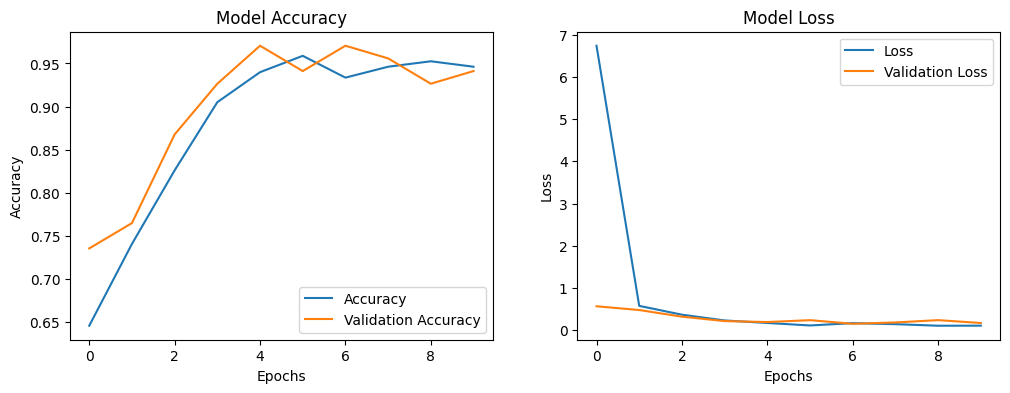

In [ ]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
f1 = f1_score(y_test, y_pred)

print(f'F1-Score: {f1}')
print(classification_report(y_test, y_pred, target_names=['Norm', 'Patho']))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step
F1-Score: 0.9615384615384616
              precision    recall  f1-score   support

        Norm       0.88      0.88      0.88        16
       Patho       0.96      0.96      0.96        52

    accuracy                           0.94        68
   macro avg       0.92      0.92      0.92        68
weighted avg       0.94      0.94      0.94        68



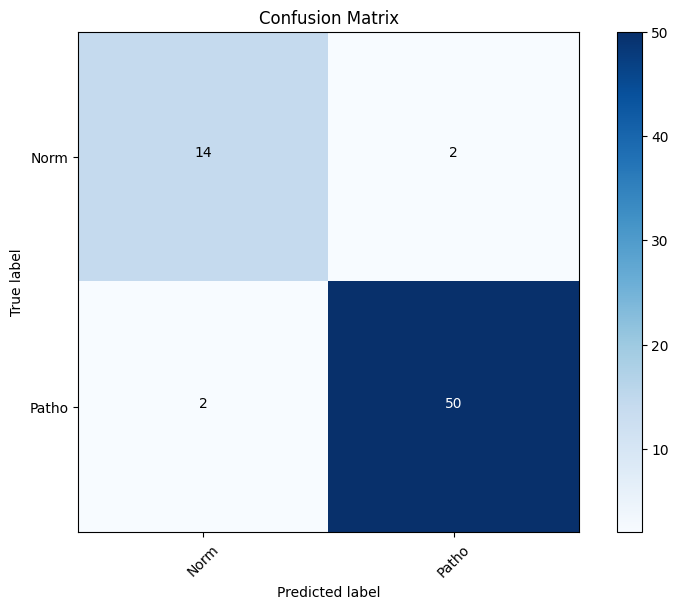

In [ ]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Norm', 'Patho'], rotation=45)
plt.yticks(tick_marks, ['Norm', 'Patho'])

thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Modelo (Optimizado)
- **Búsqueda de hiperparámetros:** Utiliza keras_tuner para encontrar los mejores hiperparámetros a partir de un rango definido. Esto incluye el número de filtros, el tamaño del kernel, el número de unidades en la capa densa, la tasa de dropout y la tasa de aprendizaje.
- **Arquitectura ajustable:** La arquitectura del modelo se ajusta dinámicamente según los mejores hiperparámetros encontrados por keras_tuner.

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values=[3,5]),
        activation='relu',
        input_shape=(images.shape[1], images.shape[2], images.shape[3])
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values=[3,5]),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_3_kernel', values=[3,5]),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='Modelo Optimizado',
    project_name='tesisModel'
)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
El mejor número de filtros en la primera capa convolucional es {best_hps.get('conv_1_filter')}.
El mejor tamaño de kernel en la primera capa convolucional es {best_hps.get('conv_1_kernel')}.
El mejor número de filtros en la segunda capa convolucional es {best_hps.get('conv_2_filter')}.
El mejor tamaño de kernel en la segunda capa convolucional es {best_hps.get('conv_2_kernel')}.
El mejor número de filtros en la tercera capa convolucional es {best_hps.get('conv_3_filter')}.
El mejor tamaño de kernel en la tercera capa convolucional es {best_hps.get('conv_3_kernel')}.
El mejor número de unidades en la capa densa es {best_hps.get('dense_units')}.
La mejor tasa de dropout es {best_hps.get('dropout_rate')}.
El mejor learning rate es {best_hps.get('learning_rate')}.
""")

model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Trial 5 Complete [00h 11m 54s]
val_accuracy: 0.9460784196853638

Best val_accuracy So Far: 0.9656862616539001
Total elapsed time: 01h 18m 17s

El mejor número de filtros en la primera capa convolucional es 48.
El mejor tamaño de kernel en la primera capa convolucional es 3.
El mejor número de filtros en la segunda capa convolucional es 80.
El mejor tamaño de kernel en la segunda capa convolucional es 3.
El mejor número de filtros en la tercera capa convolucional es 128.
El mejor tamaño de kernel en la tercera capa convolucional es 5.
El mejor número de unidades en la capa densa es 128.
La mejor tasa de dropout es 0.30000000000000004.
El mejor learning rate es 0.0001.

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.6797 - loss: 0.7982 - val_accuracy: 0.7647 - val_loss: 0.5140
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.7859 - loss: 0.4802 - val_accuracy: 0.8088 - val_loss: 0.4052
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8503 - 

In [ ]:
model.save('modeloOptimizadoCNN.h5')

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 306, 773, 48)   │         1,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 153, 386, 48)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 151, 384, 80)   │        34,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 75, 192, 80)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 71, 188, 128)   │       256,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 35, 94, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 421120)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    53,903,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,588,485 (620.23 MB)

 Trainable params: 54,196,161 (206.74 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 108,392,324 (413.48 MB)

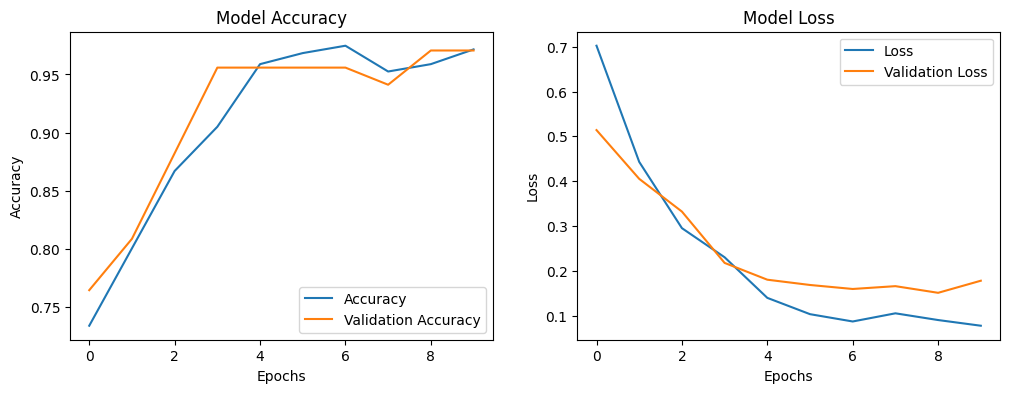

In [ ]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_test, y_pred, target_names=['Norm', 'Patho']))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step
              precision    recall  f1-score   support

        Norm       1.00      0.88      0.93        16
       Patho       0.96      1.00      0.98        52

    accuracy                           0.97        68
   macro avg       0.98      0.94      0.96        68
weighted avg       0.97      0.97      0.97        68



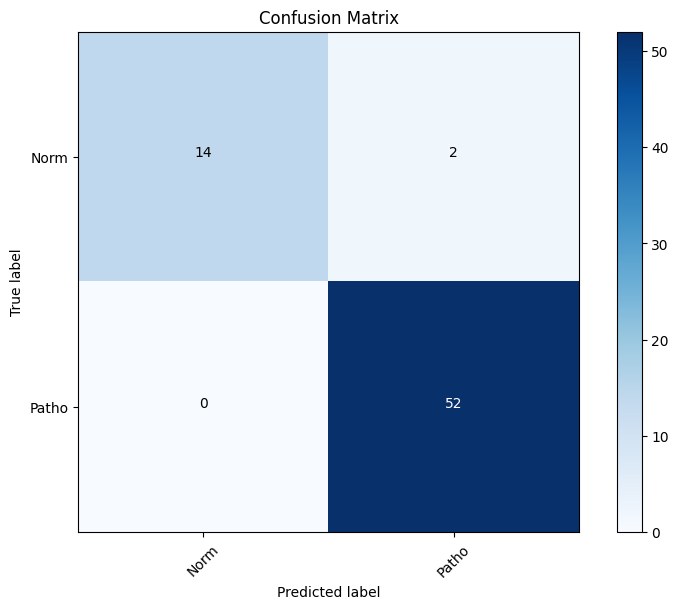

In [ ]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Norm', 'Patho'], rotation=45)
plt.yticks(tick_marks, ['Norm', 'Patho'])

thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()